In [1]:
from helper_functions import walk_through_dir

In [2]:
# !pip install scikit-learn

In [3]:
# !pip install kagglehub

Run the below cell only at first time

In [4]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("saurabhbagchi/deepfake-image-detection")

# print("Path to dataset files:", path)

In [2]:
walk_through_dir('./data')

There are 3 directories and 0 images in './data'.
There are 1 directories and 0 images in './data\Sample_fake_images'.
There are 1 directories and 0 images in './data\Sample_fake_images\Sample_fake_images'.
There are 0 directories and 5 images in './data\Sample_fake_images\Sample_fake_images\fake'.
There are 2 directories and 0 images in './data\test-20250112T065939Z-001'.
There are 0 directories and 389 images in './data\test-20250112T065939Z-001\fake'.
There are 0 directories and 110 images in './data\test-20250112T065939Z-001\real'.
There are 2 directories and 0 images in './data\train-20250112T065955Z-001'.
There are 0 directories and 153 images in './data\train-20250112T065955Z-001\fake'.
There are 0 directories and 326 images in './data\train-20250112T065955Z-001\real'.


In [3]:
train_dir = "./data/train-20250112T065955Z-001"
test_dir = "./data/test-20250112T065939Z-001"

In [51]:
import tensorflow as tf

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 4

train_data_10 = (
    tf.keras.preprocessing.image_dataset_from_directory(
        train_dir, image_size=IMAGE_SIZE, label_mode="binary", batch_size=BATCH_SIZE
    )
    .map(lambda x, y: (tf.keras.applications.resnet.preprocess_input(x), tf.cast(y, tf.int32)))
)

test_data = (
    tf.keras.preprocessing.image_dataset_from_directory(
        test_dir, image_size=IMAGE_SIZE, label_mode="binary", batch_size=BATCH_SIZE
    )
    .map(lambda x, y: (tf.keras.applications.resnet.preprocess_input(x), tf.cast(y, tf.int32)))
)


Found 479 files belonging to 2 classes.
Found 499 files belonging to 2 classes.


In [52]:
test_data

<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))>

This output represents a TensorFlow PrefetchDataset object. Let's break down what that means:

PrefetchDataset: This is a crucial optimization technique in TensorFlow for improving training performance.  It allows the input pipeline to prefetch elements before they are needed by the training loop.  Think of it like a waiter pre-filling water glasses; the training loop (the customer) doesn't have to wait for the data to be loaded and processed, it's already available.  This overlaps data preprocessing with model training, significantly reducing idle time.

element_spec: This describes the structure of the data elements within the dataset.  It tells you what kind of data to expect (tensors, in this case) and their shapes and data types.

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)): This tuple indicates that each element in the dataset is itself a tuple containing two tensors.

TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None): This is the first tensor.
shape=(None, 224, 224, 3): This is the shape of the tensor.
None: This represents the batch size. It's None because the PrefetchDataset can handle batches of varying sizes. The actual batch size is determined during training.
224, 224: These likely represent the height and width of an image (in pixels).
3: This likely represents the number of color channels (e.g., RGB for a color image).
dtype=tf.float32: This means the data type of the tensor is 32-bit floating-point numbers. This is common for image data.
TensorSpec(shape=(None, 2), dtype=tf.float32, name=None): This is the second tensor.
shape=(None, 2):
None: Again, this is the batch size.
2: This suggests that this tensor represents two values for each item in the batch. This could be a one-hot encoded label (for a classification task with two classes), or perhaps two regression targets.
dtype=tf.float32: The data type is also 32-bit floating-point.

In [38]:
# import matplotlib.pyplot as plt

# test_data = test_data / 255.0 #cannot divide in pipeline of data as it is not the data
# test_data.class_names # we get diffrent class names there are various other methods one can explore
# for images,labels in test_data.take(1):#Takes one batch
#   images_np = images.numpy()
#   # Now you can normalize the NumPy array:
#   images_np = images_np / 255.0 
#   plt.imshow(images_np[25]) #If you get an error, make sure image is of type uint8 by using the line aboves

    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.580536..147.672].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..149.45383].


[[1]
 [1]
 [0]
 [1]]


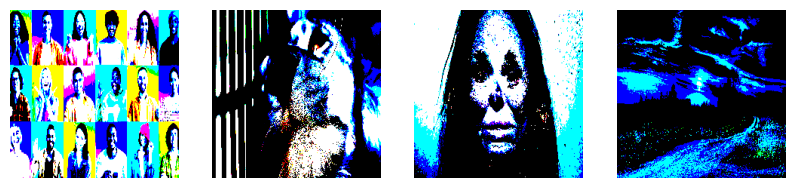

In [55]:
from random import randint
import matplotlib.pyplot as plt
import random
# Take one batch of images and labels
for images, labels in train_data_10.take(1):
    images_np = images.numpy()  # Convert Tensor to NumPy array
    labels_np = labels.numpy()  # Convert Tensor to NumPy array
    print(labels_np)
    
    plt.figure(figsize=(10, 10))
    for i in range(min(BATCH_SIZE, 8)):  # Display up to 8 images
        plt.subplot(2, 4, i + 1)
        plt.imshow(images_np[i])  # Show image
        plt.axis("off")  # Hide axes
    plt.show()


#Building baseline model using functional api as it is more flexible than sequential api

The include_top parameter is a crucial setting when working with pre-trained models in deep learning, especially for transfer learning. It determines whether or not to include the top (or final, classification) layers of the pre-trained model in your new model.

# For resnet we need rescaling 1./255 but for efficient net we dont need rescaling 

In [10]:
# from turtle import shape
# import tf_keras
# import tensorflow_hub as hub
# m1 = "https://tfhub.dev/tensorflow/efficientnet/b0/classification/1"
# # m2 = "https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/101-classification/2"
# def create_model(url, IMAGE_SHAPE, num_classes=2, include_top=False):
#     """Creates a TensorFlow/Keras model using a Hub layer.

#     Args:
#         url: URL of the TensorFlow Hub model.
#         IMAGE_SHAPE: Tuple representing the image shape (height, width).
#         num_classes: Number of output classes.
#         include_top: Whether to include the classification head of the
#             pre-trained model. If False, a new Dense layer is added.

#     Returns:
#         A TensorFlow/Keras model.
#     """

#     hub_layer = hub.KerasLayer(url, input_shape=IMAGE_SHAPE + (3,),
#                              trainable=False)  # Freeze the Hub layer

#     if include_top:
#         model = tf_keras.Sequential([
#             hub_layer,  # Include the original classification head
#             tf_keras.layers.Activation('softmax', name="Output_Layer")  # Add softmax for consistency
#         ])
#     else:
#         input = tf.keras.layers.Input(shape=(224,224,3), name="input_layer") # we are using functional api
#         # x = hub_layer (input) will not work
#         # inputs = keras.Input(shape=(None, None, 3))
#         x = hub_layer(input)
#         # print(f"Shape after passing to the base model : {x.shape}")
#         # x = tf.keras.layers.GlobalAveragePooling2D(name= "GAP")(x)
#         # print(f"Shape after GAP : {x.shape}")
#         output = tf.keras.layers.Dense(num_classes,activation="softmax", name = "output_layer")(x)
#         model = tf.keras.Model(input=input,outputs=output)
        
#     return model
# # model1 = create_model(m1,4)

In [11]:
# model1 = create_model(m1,IMAGE_SIZE,num_classes=2) # trainable is by default false so only output layer wts change

In [12]:
# import tf_keras
# import tensorflow_hub as hub
# m1 = "https://tfhub.dev/tensorflow/efficientnet/b0/classification/1"
# def create_model(url,num_classes=10):
#     classifier = tf_keras.Sequential([
#     hub.KerasLayer(url, input_shape=IMAGE_SIZE+(3,),trainable=False)
#     ])
#     model = tf_keras.Sequential([classifier,
#             tf_keras.layers.Dense(num_classes,activation="softmax",name="Output_Layer")])
#     return model

In [13]:
# model1 = create_model(m1,num_classes=2)

In [14]:
# model1.summary()

In [15]:
# model1.compile(loss ="categorical_crossentropy",
#                optimizer = tf_keras.optimizers.Adam(),
#                metrics= ["accuracy"])

In [16]:
# # history1 = model1.fit(train_data_10,steps_per_epoch=int(0.50 *len(train_data_10)),epochs=5,validation_data=test_data,validation_steps=int(0.25 * len(test_data)))
# # Baseline model on 50 % training data and 25%testing data

# history1 = model1.fit(train_data_10,steps_per_epoch=len(train_data_10),epochs=5,validation_data=test_data,validation_steps=len(test_data))

In [17]:
# model1.evaluate(test_data)

In [66]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
    loss = history.history ["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))
    plt.plot(epochs,loss,label="training_loss")
    plt.plot(epochs,val_loss,label="val_loss")
    plt.title("Loss and accuracy")
    plt.xlabel("Epoches")
    plt.plot(epochs,accuracy,label="accuracy")
    plt.plot(epochs,val_accuracy,label="val_accuracy")
    plt.legend()

In [57]:
# plot_loss_curves(history1)

In [58]:
from os import name
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Define input shape
input_shape = (224, 224, 3)


# Define input tensor
inputs = Input(shape=input_shape)

# Create ResNet50 model using functional API
resnet_model = ResNet50(
    include_top=False,  # Remove the original classification head
    weights='imagenet', 
    input_tensor=inputs, 
    pooling='avg', 
)
resnet_model.trainable = False #First model which is base line model must be non trainable
# Add a new classification head
x = Dense(256, activation='relu')(resnet_model.output) 
x = Dense(128, activation='relu')(x) 
# x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(resnet_model.output)
outputs = Dense(1, activation='sigmoid')(x)  # Change from softmax to sigmoid

# Create the final model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=Adam(), 
              loss='binary_crossentropy',  
              metrics=['accuracy'])

In [59]:
# # # history1 = model1.fit(train_data_10,steps_per_epoch=int(0.50 *len(train_data_10)),epochs=5,validation_data=test_data,validation_steps=int(0.25 * len(test_data)))
# # Baseline model on 50 % training data and 25%testing data

history = model.fit(train_data_10,steps_per_epoch=len(train_data_10),epochs=5,validation_data=test_data,validation_steps=len(test_data))

Epoch 1/5
120/120 [==============================] - 8s 46ms/step - loss: 0.6889 - accuracy: 0.7140 - val_loss: 0.3691 - val_accuracy: 0.8136
Epoch 2/5
120/120 [==============================] - 6s 42ms/step - loss: 0.3508 - accuracy: 0.8413 - val_loss: 0.3564 - val_accuracy: 0.8477
Epoch 3/5
120/120 [==============================] - 5s 41ms/step - loss: 0.2428 - accuracy: 0.8852 - val_loss: 0.6065 - val_accuracy: 0.7695
Epoch 4/5
120/120 [==============================] - 5s 41ms/step - loss: 0.1396 - accuracy: 0.9520 - val_loss: 1.2251 - val_accuracy: 0.7074
Epoch 5/5
120/120 [==============================] - 5s 41ms/step - loss: 0.0915 - accuracy: 0.9624 - val_loss: 1.2454 - val_accuracy: 0.7275


In [60]:
def prediction(model,data):
    y_pred = model.predict(test_data)
    print(y_pred[:10])  # Check first 10 predictions
    plt.plot(y_pred)
    return y_pred.mean()  

125/125 [==============================] - 3s 19ms/step
[[9.9370182e-01]
 [1.1289455e-05]
 [9.8325688e-01]
 [1.5214700e-01]
 [9.9967802e-01]
 [4.2481530e-02]
 [1.1860707e-01]
 [9.9974602e-01]
 [9.9985361e-01]
 [8.9766294e-01]]


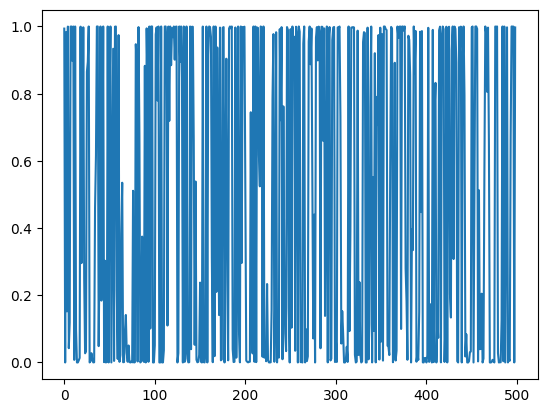

In [61]:
y_pred_mean = prediction(model=model,data=test_data)

In [62]:
def Confusion_matrix(model,test_data):
    # Get predictions
    y_true = []
    y_pred = []
    import numpy as np
    import tensorflow as tf
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    for images, labels in test_data:
        labels_np = labels.numpy().astype(int)  # Already binary (0 or 1)
        preds = model.predict(images)  # Get model predictions
        THRESHOLD = 0.5  # Try adjusting this value
        preds_binary = (preds > THRESHOLD).astype(int)
        
        y_pred.extend(preds_binary.flatten())  # Flatten to 1D array
        y_true.extend(labels_np.flatten())  # Flatten labels to 1D array

    # Convert lists to NumPy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Display Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

I have set the threshold as the data is imabalanced and therefore to balance out data Threshold = 0.72

1/1 [==============================] - 0s 22ms/step


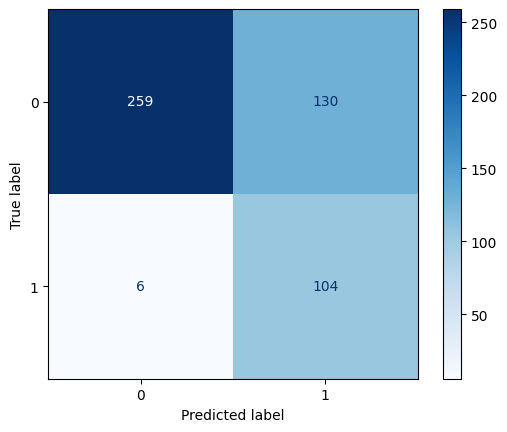

In [64]:
# Confusion_matrix(model=model,test_data=test_data,THRESHOLD=0.72)
Confusion_matrix(model=model,test_data=test_data)

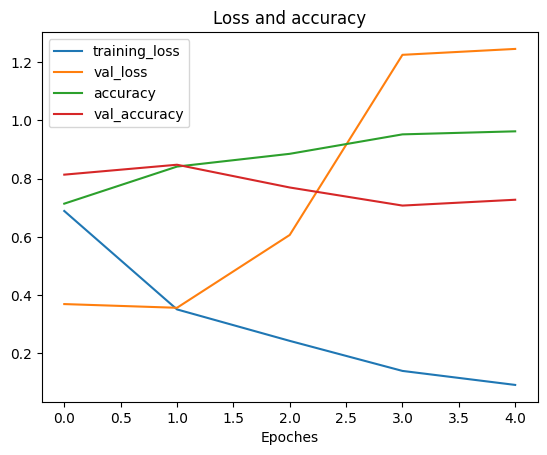

In [67]:
plot_loss_curves(history)

In [68]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

The base model already has a globalpooling layer in it but, what it does is that it reduces the dimensions (4D -> 2D)

In [69]:
Input_shape = (1,4,4,2)
tf.random.set_seed(45)
input_tensor = tf.random.normal(Input_shape)# Returns a tensor
print(input_tensor)

tf.Tensor(
[[[[ 1.1169435  -0.4273953 ]
   [ 0.6175963  -0.02282433]
   [ 1.5468441  -0.13980214]
   [ 1.7462788   0.25064424]]

  [[ 2.0873473   1.9916135 ]
   [ 0.7068687  -1.3067623 ]
   [-0.444976   -0.28310922]
   [-0.9675712  -0.41566622]]

  [[ 0.87176013  0.3110196 ]
   [-0.91191435  1.7441009 ]
   [-1.0759017   0.7387565 ]
   [-0.7981351   1.108516  ]]

  [[-1.117791   -0.46879998]
   [-0.8678816  -0.14412855]
   [ 0.09312417 -0.6751593 ]
   [ 1.1796412  -0.29154217]]]], shape=(1, 4, 4, 2), dtype=float32)


In [70]:
output_layer = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(output_layer)

tf.Tensor([[0.23638958 0.12309132]], shape=(1, 2), dtype=float32)


The pooling condenses it into smaller vector

# Feature Extraction is named as the pretrained model outputs a featurevector of 2 dimensions or a long list of features that the model has learned in a condensed form which can then be used to extract patterns out of our own specefic problems

tf.Tensor([[0.23638958 0.12309132]], shape=(1, 2), dtype=float32)

# Running a series of Experiments
Same test dataset will be used to ensure the consistency

1) model1 :- data augmentation will be added
2) model2 :- more complex models with trainable parameter true (finetuning)
3) model3 :- Using techniques to reduce overfitting

to add augmentation we can add layers in model tf.keras.layers

Image preprocessing
These layers are for standardizing the inputs of an image model.

tf.keras.layers.Resizing: resizes a batch of images to a target size.
tf.keras.layers.Rescaling: rescales and offsets the values of a batch of images (e.g. go from inputs in the [0, 255] range to inputs in the [0, 1] range.
tf.keras.layers.CenterCrop: returns a center crop of a batch of images.
Image data augmentation
These layers apply random augmentation transforms to a batch of images. They are only active during training.

tf.keras.layers.RandomCrop
tf.keras.layers.RandomFlip
tf.keras.layers.RandomTranslation
tf.keras.layers.RandomRotation
tf.keras.layers.RandomZoom
tf.keras.layers.RandomContrast

# Benefits of Augmentation inside a model (works only on traing data) is that it accelerates with GPU 

Whereas using imagedata generator it will use the cpu power

In [71]:
# # For augmentation we will use image data generator
# from tensorflow.keras.preprocessing.image import ImageDataGenerator # but we have the data already so 
from tensorflow.keras import layers


In [72]:
# data_augmentation = tf.keras.Sequential([
#     # layers.RandomZoom(height_factor=(0.2,0.4),fill_mode='wrap'),
#     # layers.RandomZoom(height_factor=(0.2,0.4)),#Defualt mode to fill
#     layers.RandomTranslation(height_factor=(-0.2, 0.3),width_factor=(-0.2, 0.3)), 
#     layers.RandomContrast(0.2)
# ])
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
], name="data_augmentation")

In [73]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

[1. 0.] means the image belongs to class 0.
[0. 1.] means the image belongs to class 1.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.49142..144.98956].


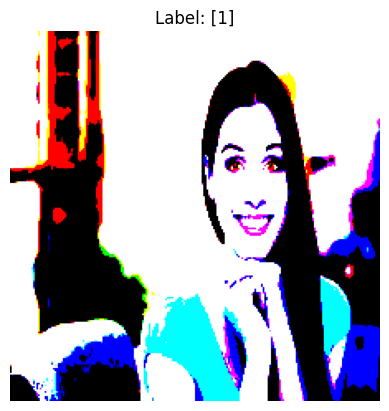

In [74]:
# Take one batch from the dataset
for images, labels in train_data_10.take(random.randint(1,len(train_data_10))):
    images_np = images.numpy()  # Convert images to NumPy array
    labels_np = labels.numpy()  # Convert labels to NumPy array

    # Pick a random index from the batch
random_idx = random.randint(0, BATCH_SIZE - 1)

 # Display the image
plt.imshow(images_np[random_idx])
plt.axis("off")  # Hide axes
plt.title(f"Label: {labels_np[random_idx]}")  # Show label
# plt.title("Original image")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-118.708435..107.818565].


(-0.5, 223.5, 223.5, -0.5)

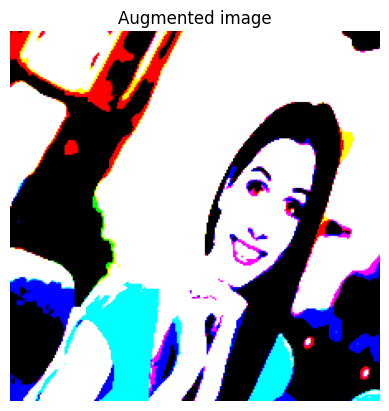

In [75]:
# Lets Augment it 
augmented_img = data_augmentation(images_np[random_idx],training=True)
# augmented_img
plt.imshow(augmented_img)
plt.title("Augmented image")
plt.axis("off")

# model 1
1️. Data Augmentation in model1
model1 includes data_augmentation(inputs), which applies data augmentation techniques before passing images into ResNet50.
model does not have any augmentation, meaning the input data remains unchanged.

2️. Flatten vs Direct Dense Layers
model1 uses Flatten() to convert the feature maps from ResNet50 into a 1D vector before passing it through dense layers.
model directly applies Dense layers to the output of ResNet50 (which has pooling='avg').

3️. Regularization in model1
model1 adds L2 regularization (kernel_regularizer=tf.keras.regularizers.l2(0.01)) in the first Dense layer to prevent overfitting.
model does not use any regularization.

4️. Dropout for Overfitting Prevention
model1 has a Dropout layer (0.5 probability) after the first Dense layer to reduce overfitting.
model does not use Dropout.

5️. Number of Neurons in Dense Layers
model has a 256-unit Dense layer followed by a 128-unit Dense layer before the final output.
model1 only has one 128-unit Dense layer before the final output.

6️. Initialization of Input to ResNet
In model, the input tensor is directly passed into ResNet50.
In model1, the augmented input (x) is passed to ResNet50.


In [ ]:
# Define input shape
input_shape = (224, 224, 3)

# Define input tensor
inputs = Input(shape=input_shape)
x = data_augmentation (inputs)

resnet_model = ResNet50(
    include_top=False,  
    weights='imagenet', 
    input_tensor=x, 
    pooling='avg', 
)
resnet_model.trainable = False # non trainable

# Add Flatten to convert feature maps into a vector

x = tf.keras.layers.Flatten()(resnet_model.output)

x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = tf.keras.layers.Dropout(0.5)(x)

# x = Dense(128, activation='relu')(x) 
# x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(resnet_model.output)
outputs = Dense(1, activation='sigmoid')(x) 

# Create the final model
model1 = Model(inputs=inputs, outputs=outputs)

# Compile the model
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',  # Use binary crossentropy for binary classification
              metrics=['accuracy'])

<outputs = Dense(2, activation='softmax')(x)> This is a layer  
if it is a model then we pass it inside the model <x = data_augmentation (inputs)>   

In [77]:
history1 = model1.fit(train_data_10,steps_per_epoch=len(train_data_10),epochs=5,validation_data=test_data,validation_steps=len(test_data))

Epoch 1/5
120/120 [==============================] - 13s 64ms/step - loss: 2.4004 - accuracy: 0.6514 - val_loss: 1.9991 - val_accuracy: 0.4008
Epoch 2/5
120/120 [==============================] - 8s 64ms/step - loss: 1.3728 - accuracy: 0.7641 - val_loss: 1.4886 - val_accuracy: 0.5691
Epoch 3/5
120/120 [==============================] - 7s 52ms/step - loss: 1.0999 - accuracy: 0.7537 - val_loss: 1.1162 - val_accuracy: 0.7094
Epoch 4/5
120/120 [==============================] - 7s 50ms/step - loss: 0.9446 - accuracy: 0.7954 - val_loss: 1.3238 - val_accuracy: 0.5431
Epoch 5/5
120/120 [==============================] - 6s 49ms/step - loss: 0.8034 - accuracy: 0.8225 - val_loss: 0.8695 - val_accuracy: 0.7575


125/125 [==============================] - 3s 16ms/step
[[0.49138194]
 [0.04883895]
 [0.09367707]
 [0.3791011 ]
 [0.5039443 ]
 [0.8577165 ]
 [0.98417085]
 [0.04622748]
 [0.9937621 ]
 [0.2412495 ]]


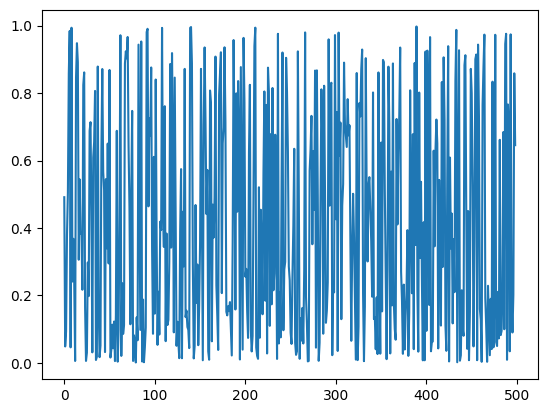

In [78]:
y_pred_mean = prediction(model1,test_data)

1/1 [==============================] - 0s 21ms/step


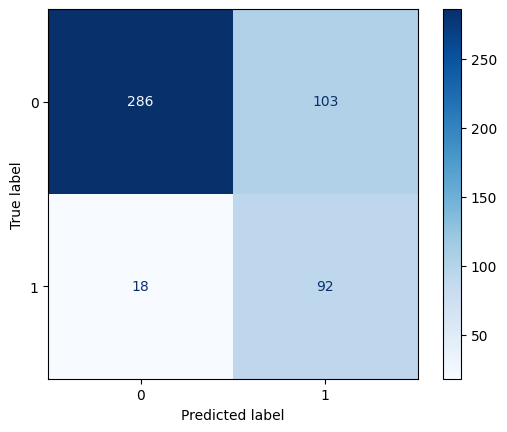

In [80]:
Confusion_matrix(model1,test_data)

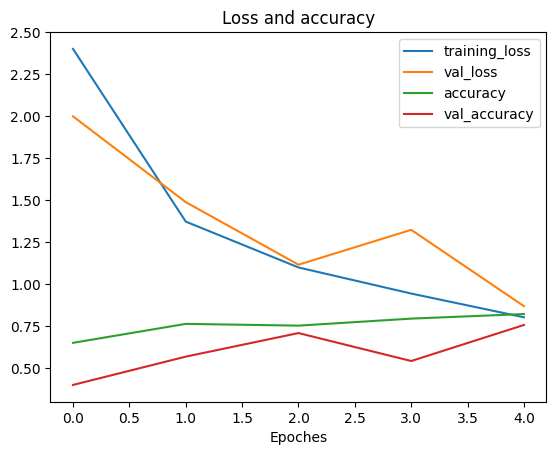

In [82]:
plot_loss_curves(history1)

# Model 2 (trainable = True)(finetuning)

1) Setting trainable parameter 2 so that the weights of resnet50 are unfrozen

In [97]:
from os import name
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Define input shape
input_shape = (224, 224, 3)


# Define input tensor
inputs = Input(shape=input_shape)

# Create ResNet50 model using functional API
resnet_model = ResNet50(
    include_top=False,  # Remove the original classification head
    weights='imagenet', 
    input_tensor=inputs, 
    pooling='avg', 
)
resnet_model.trainable = True #First model which is base line model must be non trainable

# Add Flatten to convert feature maps into a vector

x = tf.keras.layers.Flatten()(resnet_model.output)

x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = tf.keras.layers.Dropout(0.5)(x)

# x = Dense(128, activation='relu')(x) 
# x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(resnet_model.output)
outputs = Dense(1, activation='sigmoid')(x) 

# Create the final model
model2 = Model(inputs=inputs, outputs=outputs)

# Compile the model
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',  # Use binary crossentropy for binary classification
              metrics=['accuracy'])

Adding callbacks like TensorBoard Model checkpointing and early stoppings can be helpful

Full model or only weights can be saved intermediately in a modeling process

In [98]:
def checkpoint(n):
    path = f"E:/human/Deepfake/Checkpoint/model_{n}" 
    checkpoint_callbacks= tf.keras.callbacks.ModelCheckpoint(filepath=path,save_weights_only=True,save_best_only=False,verbose=1)
    return checkpoint_callbacks

In [99]:
from helper_functions import create_tensorboard_callback
history2 = model2.fit(train_data_10,steps_per_epoch=len(train_data_10),epochs=5,validation_data=test_data,validation_steps=len(test_data),callbacks=[create_tensorboard_callback(dir_name="Checkpoint",experiment_name="Model 2"),checkpoint(2)])

Saving TensorBoard log files to: Checkpoint/Model 2/20250209-115753
Epoch 1/5
120/120 [==============================] - ETA: 0s - loss: 2.0815 - accuracy: 0.6388
Epoch 1: saving model to E:/human/Deepfake/Checkpoint\model_2
120/120 [==============================] - 17s 91ms/step - loss: 2.0815 - accuracy: 0.6388 - val_loss: 17.4224 - val_accuracy: 0.2325
Epoch 2/5
119/120 [============================>.] - ETA: 0s - loss: 1.1467 - accuracy: 0.6597
Epoch 2: saving model to E:/human/Deepfake/Checkpoint\model_2
120/120 [==============================] - 11s 82ms/step - loss: 1.1453 - accuracy: 0.6597 - val_loss: 62.8548 - val_accuracy: 0.2204
Epoch 3/5
119/120 [============================>.] - ETA: 0s - loss: 0.8477 - accuracy: 0.6807
Epoch 3: saving model to E:/human/Deepfake/Checkpoint\model_2
120/120 [==============================] - 10s 78ms/step - loss: 0.8475 - accuracy: 0.6785 - val_loss: 4.2772 - val_accuracy: 0.7234
Epoch 4/5
119/120 [============================>.] - ETA: 0s

125/125 [==============================] - 3s 18ms/step
[[0.63642585]
 [0.5770834 ]
 [0.7176763 ]
 [0.62723756]
 [0.65974104]
 [0.7547475 ]
 [0.8596497 ]
 [0.8946188 ]
 [0.59272325]
 [0.8528451 ]]


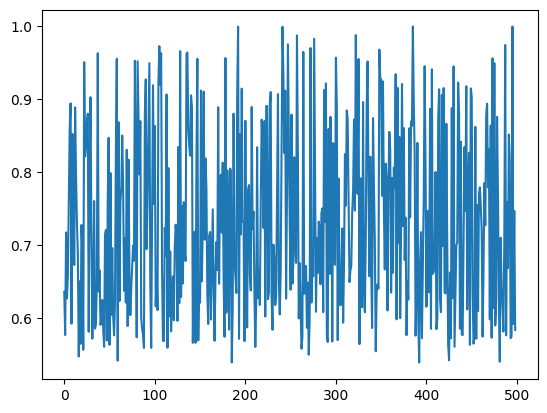

In [100]:
y_pred_mean = prediction(model2,test_data)

1/1 [==============================] - 0s 22ms/step


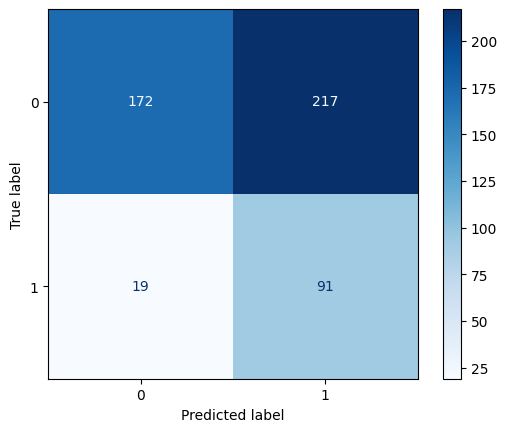

In [87]:
Confusion_matrix(model2,test_data)

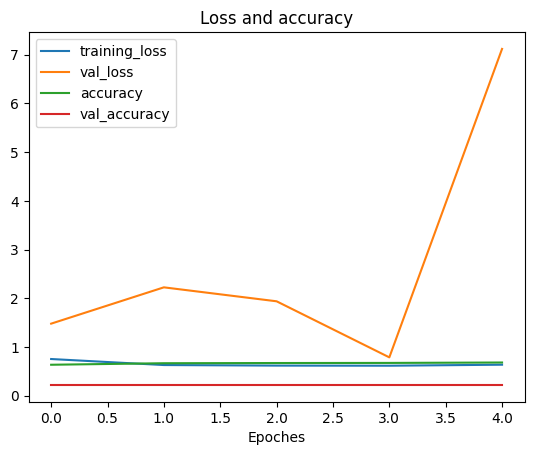

In [95]:
plot_loss_curves(history2)

💡 3. Overfitting Due to Small Dataset or Large Model

If your dataset is small, ResNet50 might be too complex.
Consider reducing the number of trainable layers or using a simpler model.

Model 3 , setting only few layers as trainable and adding batch normalization

In [ ]:
from os import name
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Define input shape
input_shape = (224, 224, 3)


# Define input tensor
inputs = Input(shape=input_shape)

# Create ResNet50 model using functional API
resnet_model = ResNet50(
    include_top=False,  # Remove the original classification head
    weights='imagenet', 
    input_tensor=inputs, 
    pooling='avg', 
)
# resnet_model.trainable = True #First model which is base line model must be non trainable
for layer in resnet_model.layers[:-10]:  # Only fine-tune last 10 layers
    layer.trainable = False

# Add Flatten to convert feature maps into a vector

x = tf.keras.layers.Flatten()(resnet_model.output)

x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

# x = Dense(128, activation='relu')(x) 
# x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(resnet_model.output)
outputs = Dense(1, activation='sigmoid')(x) 

# Create the final model
model3 = Model(inputs=inputs, outputs=outputs)

# Compile the model
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',  # Use binary crossentropy for binary classification
              metrics=['accuracy'])

In [ ]:
from helper_functions import create_tensorboard_callback
history3 = model3.fit(train_data_10,steps_per_epoch=len(train_data_10),epochs=5,validation_data=test_data,validation_steps=len(test_data),callbacks=[create_tensorboard_callback(dir_name="Checkpoint",experiment_name="Model 2"),checkpoint(2)])